# Functions designed to upsize and downsize

We assume that we don't downsize in one dimension and upsize in another dimension. Two main functions are defined. An up-sizing function with billinear and cubic interpolation along with both guassian and average convolutions for down-sizing.

In [1]:
import numpy as np
import cv2

In [2]:
import pdb

In [3]:
arr = np.ones((640, 640, 3), dtype = np.uint8)

In [4]:
from Export.nb_PixelManipulation import *
from Export.nb_HistogramEqualisation import *

## Coordinate Transformation

In [6]:
#export
def calcualteSizeTransParams(old_dim, target_dim):
    a = (old_dim - 2)/target_dim
    b = 0.5
    return lambda x : a * x + b

def createPixelTransform(old_size, target_size):
    y_resize = calcualteSizeTransParams(old_size[0], target_size[0])
    x_resize = calcualteSizeTransParams(old_size[1], target_size[1])
    return lambda x, y : (x_resize(x), y_resize(y))

In [7]:
test_func = calcualteSizeTransParams(4, 7)

In [8]:
test_func(0)

0.5

In [9]:
px_trans = createPixelTransform((4,4), (7,7))

In [10]:
px_trans(7,7)

(2.5, 2.5)

In [11]:
frog_img = cv2.imread('Images/dat_boi.jpg')

In [12]:
frog_small = cv2.resize(frog_img, dsize = (160, 160), interpolation = cv2.INTER_AREA)

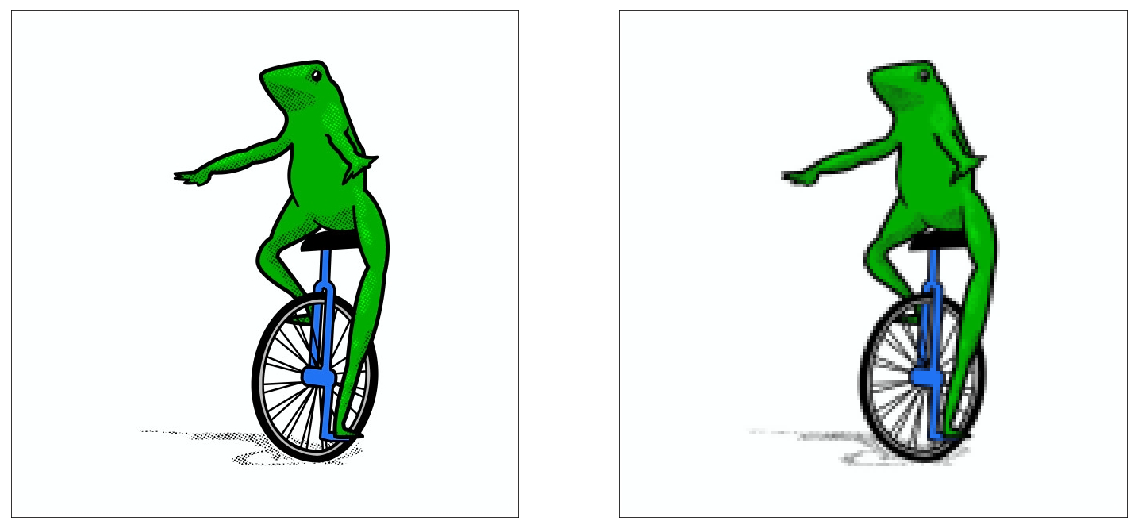

In [13]:
compareTwoImages(frog_img, frog_small)

In [14]:
#export

def extractPxWindow(px, img):
    i, j = px
    return np.ndarray((4,3), 
        dtype = np.uint8,
        buffer = np.array([img[i, j, :], 
        img[i, j + 1, :], 
        img[i + 1, j, :], 
        img[i + 1, j + 1, :]])
    )

def getTargetIndices(float_px):
    px1, px2 = np.int32(np.floor(float_px))
    return np.ndarray((4,2), 
        dtype = np.int32,
        buffer = np.array([px1, px2, px1, px2 + 1, px1 + 1, px2, px1 + 1, px2 + 1])
    )

def areaMultiply(px):
    return np.abs(px[0] * px[1])

def getAreaArray(float_px, target_indices):
    output = np.array([
        areaMultiply(float_px - target_indices[3]),
        areaMultiply(float_px - target_indices[2]),
        areaMultiply(float_px - target_indices[1]),
        areaMultiply(float_px - target_indices[0])
    ], dtype = np.float64)
    return output / np.sum(output)

def getValueArray(pixel_window, k):
    return np.array([
        pixel_window[0, k], pixel_window[1, k],
        pixel_window[2, k], pixel_window[3, k]
    ], dtype = np.float64)

def areaInterpolation(pixel_window, float_px, target_indices, k):
    a = getAreaArray(float_px, target_indices)
    v = getValueArray(pixel_window, k)
    return np.uint8(np.rint(np.dot(a, v)))
    
def upsizeImage(img, target_size, interpolation_method):
        
    img, height, width, channels, im_size = getChannels(img)
    target_hei, target_wid, target_chn = target_size
    if target_chn != channels : print('Target channels not equal to input.'); return
    px_transform = createPixelTransform((height, width), target_size)
    output_img = np.zeros(target_size, dtype = np.uint8)
    chan_last_ind = channels - 1
    
    i, j, k = 0, 0, 0
    update_window = True
    float_coord = np.array([0.5, 0.5], dtype = np.float64)
    target_inds  = getTargetIndices(float_coord)
    last_inds = target_inds[0]
    pixel_window = extractPxWindow(last_inds, img)
    for px in np.nditer(output_img, op_flags = ['writeonly']):
        px[...] = areaInterpolation(pixel_window, float_coord, target_inds, k)
        if np.any(np.int32(np.floor(float_coord)) != last_inds):
            pixel_window = extractPxWindow(target_inds[0], img)
            target_inds  = getTargetIndices(float_coord)
            last_inds = target_inds[0]
        i, j, k = iterateImage(i, j, k, channels, target_wid)
        float_coord = px_transform(i, j)
    return output_img

In [15]:
frog_resize = upsizeImage(frog_small, (640, 640, 3), None)

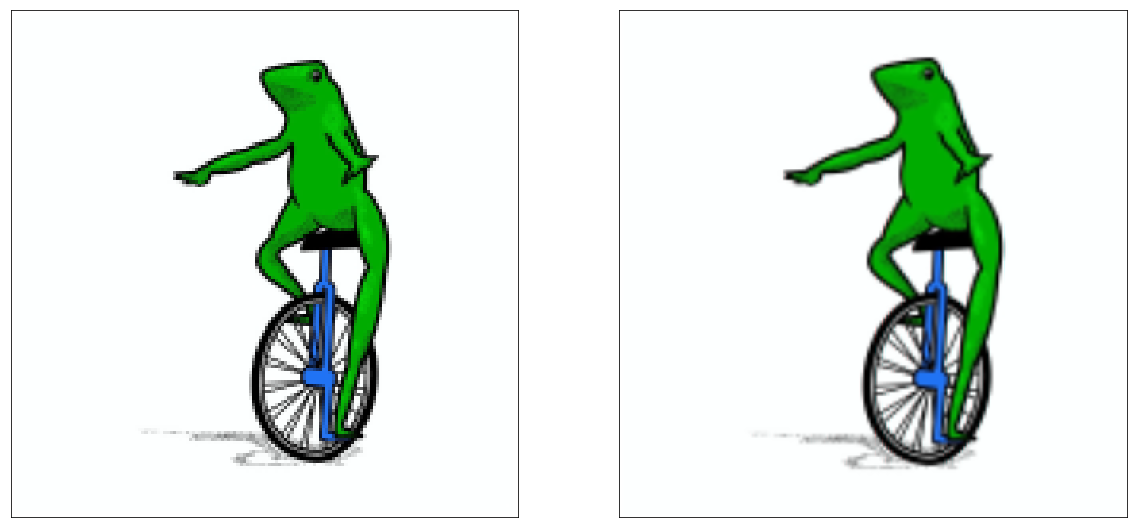

In [17]:
compareTwoImages(frog_small, frog_resize)

## Export

In [18]:
!python notebook2script.py ResizingMethods.ipynb

Converted ResizingMethods.ipynb to Export\nb_ResizingMethods.py
